## HW 2

In [160]:
import Pkg;
using Plots
using Statistics

## Helper functions

In [161]:
# create m random vectors of floats in the range [a,b]
function rand_population_uniform(m, dim, a, b)
    # m: how many individuals to create.
    # dim: the dimensions of the individuals
    # a: the lowest value allowed
    # b: the highest value allowed
    # return m vectors of dim dimensions, each dimension has a value randomly distributed from a to b.
    
    return [a.+rand(dim).*(b-a) for i in 1:m]
end

rand_population_uniform (generic function with 1 method)

In [162]:
abstract type CrossoverMethod end

struct SinglePointCrossover <: CrossoverMethod end
function crossover(c::SinglePointCrossover, a, b)
    # a: first vector in the crossover
    # b: second vector in the crossover
    # return the two new vectors created from the crossover.

    # assume a and b are the same dimension.
    i = rand(1:length(a))
    children = vcat(a[1:i], b[i+1:end]), vcat(b[1:i], a[i+1:end]) 
    return children
end

crossover (generic function with 1 method)

In [163]:
abstract type MutationMethod end

struct BitwiseMutation <: MutationMethod
    λ
end
function mutate(M::BitwiseMutation, child)
    return [rand() < M.λ ? abs(v-1) : v for v in child]
end

struct UniformMut <: MutationMethod
    λ # The percentage that a mutation occurs 
    low # The lowest value to use
    high # The highest value to use
end
function mutate(M::UniformMut, child)
    # child: The vector to mutate.
    # return a vector with approx λ% new values between low and high.
    return [rand() < M.λ ? (rand() * (M.high-M.low)) + M.low : v for v in child]
end

mutate (generic function with 2 methods)

In [164]:
abstract type SelectionMethod end

function roulette_selection(weights)
    # weights: the weights to complete the roulette selection on.
    # return the selection as an index.
    
    running_sum = 0
    selected_index = -1
    sum_fitness = sum(weights)
    selection = rand() * sum_fitness
    
    for weight_index in 1:length(weights)
        running_sum += weights[weight_index]
        
        if selection < running_sum && selected_index == -1
            selected_index = weight_index
        end
    end
    return selected_index
end

struct RouletteSelection <: SelectionMethod end

function select(t::RouletteSelection, y)
    # y: the population's fitness.
    # return the y/2 parents picked by roulette selection.
    
    weights = []
    all_parents = []

    for fitness_index in 1:length(y)
        push!(weights, 1/y[fitness_index])
    end

    for i in 1:length(y)/2
        weights_copy = weights
        parents = []

        p1 = roulette_selection(weights_copy)
        #print("p1 ")
        #println(p1)
        push!(parents, p1)
        weights_copy[p1] = 0
        p2 = roulette_selection(weights_copy)
        #print("p2 ")
        #println(p2)
        push!(parents, p2)

        push!(all_parents, parents)
    end
    
    return all_parents
end

select (generic function with 1 method)

In [165]:
function flatten(list)
    # list: the list to flatten
    # return list but one less list encapsulating it.
    new_list = []
    for index in 1:length(list)
        list_element = list[index]
        for element_index in 1:length(list_element)
            push!(new_list, list_element[element_index])
        end
    end
    return new_list
end

function genetic_algorithm(f, population, max_iter, S, C, M)
    # f: fitness
    # population: initial population
    # max_iter: nubmer of iterations (generations)
    # S: selection method
    # C: crossover method
    # M: mutation method
    best = []
    best_history = zeros(max_iter)
    average_history = []
    for k in 1:max_iter
        #println("generation: ", k)
        #println(" population: ", population)
        #println(" avg fitness at start: ", average_fitness(population))
        parents = select(S, f.(population))
        #println(f.(population))
        #println(parents)
        #println("parents: ", parents)
        #println(population[parents[1][1]], " + ")
        #println(population[parents[1][2]])
        #println()
        children = [crossover(C,population[p[1]],population[p[2]]) for p in parents]
        children = flatten(children)
        #print(children[1])
        #println()
        #println()
        #println("children: ", children)
        #println(" avg fitness after S+C: ", average_fitness(children))
        #println(children[1])
        population = [ mutate(M, child) for child in children ]
        #println(population[1])
        #println(" avg fitness after M: ", average_fitness(population))
        if best == [] || f(best) > f(population[argmin(f.(population))]) 
            best = population[argmin(f.(population))]
        end
        push!(average_history, mean(f.(population)))
        best_history[k] = minimum(f.(population))
        
    end
    #println("final population: ", population)
    return best, average_history, best_history
    #return population[argmin(f.(population))]
end

genetic_algorithm (generic function with 1 method)

In [166]:
function sphere(x)
    # find the dimension of the variable. save it in d.
    d = size(x)[1]
    # the Sphere as defined by https://www.sfu.ca/~ssurjano/spheref.html
    return sum([val^2 for val in x]) #+ sum(x.^2)
end

sphere (generic function with 1 method)

## a.) Plot Best Individual Cost and Populations's Average Cost as a function of Generation Number

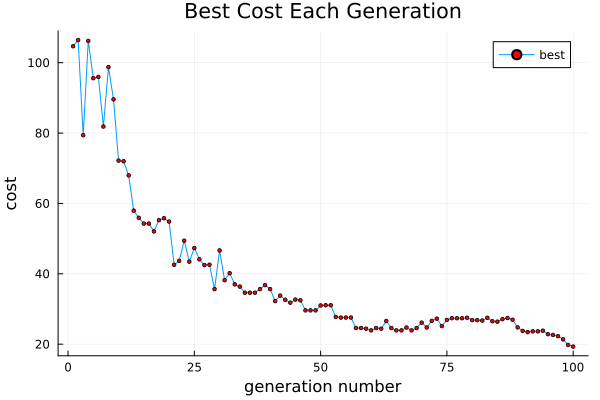

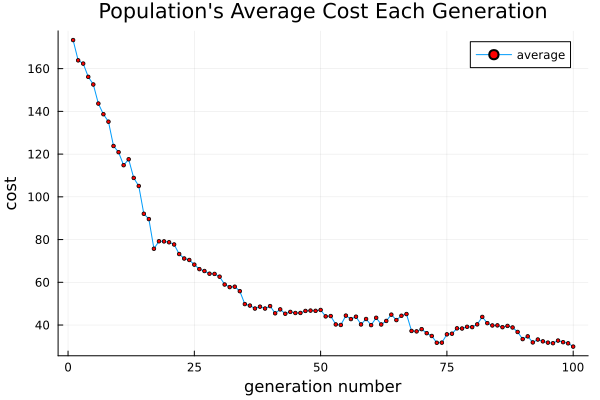

In [182]:
monte_carlo_sims = 1
max_generations = 100
pop_size = 20
dimensions = 20
S = RouletteSelection()
M = UniformMut(.01, -5, 5)
C = SinglePointCrossover()
average_history = zeros(max_generations)
best_history = zeros(max_generations)

# Number of Monte Carlo simulations
for i = 1:monte_carlo_sims

    population = rand_population_uniform(pop_size, dimensions, -5, 5)
    output, average_history, best_history = genetic_algorithm(sphere, population, max_generations, S, C, M)

    #print(output)
    #println(sphere(output))
    #println(best_history)
    #plot(best_history,1:generations:1, xlabel="x", ylabel="y", label="acceptance probability", marker=(:circle,2), seriestype=:scatter, mc=:red)
    #plot(1:generations:1,1:generations:1, xlabel="x", ylabel="y", label="acceptance probability")
end

plt1 = display(plot(1:1:max_generations, best_history, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))
plt2 = display(plot(1:1:max_generations, average_history, title="Population's Average Cost Each Generation", xlabel="generation number", ylabel="cost", label="average", marker=(:circle,2), mc=:red, reuse = false))
#plot(best_history, 1:generations, label="Bests")
#plot(average_history, 1:generations:1, label="Average")


## .b) Run 50 Monte Carlo Simulations

Cav(x*)=31.294083385748586


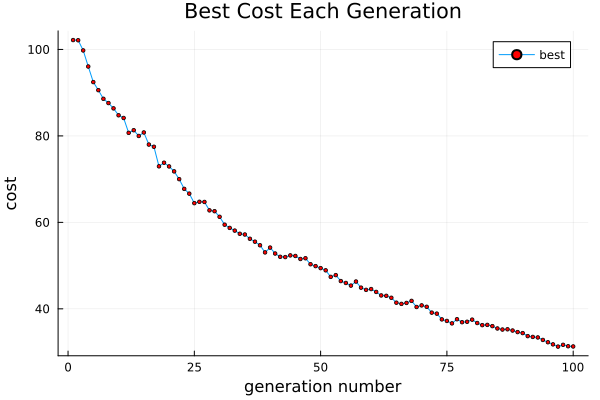

In [175]:
monte_carlo_sims = 50
max_generations = 100
pop_size = 20
dimensions = 20
min_val = zeros(monte_carlo_sims)
best_histories = []
S = RouletteSelection()
M = UniformMut(.01, -5, 5)
C = SinglePointCrossover()

# Number of Monte Carlo simulations
for i = 1:monte_carlo_sims
    
    population = rand_population_uniform(pop_size, dimensions, -5, 5)
    output, average_history, best_history = genetic_algorithm(sphere, population, max_generations, S, C, M)

    push!(best_histories, best_history)
    min_val[i] = minimum(best_history[100])
    #print(output)
    #println(sphere(output))
end

println("Cav(x*)=", mean(min_val))
mean_best_history = zeros(max_generations)
for generation_index in 1:max_generations
    sum_val = 0
    for monte_carlo_index in 1:length(best_histories)
        sum_val += best_histories[monte_carlo_index][generation_index]
    end
    mean_best_history[generation_index] = sum_val / length(best_histories)
end
display(plot(1:1:max_generations, mean_best_history, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))



## .c) Repeat B, with mutation rate of 2%

Cav(x*)=28.879542627556248


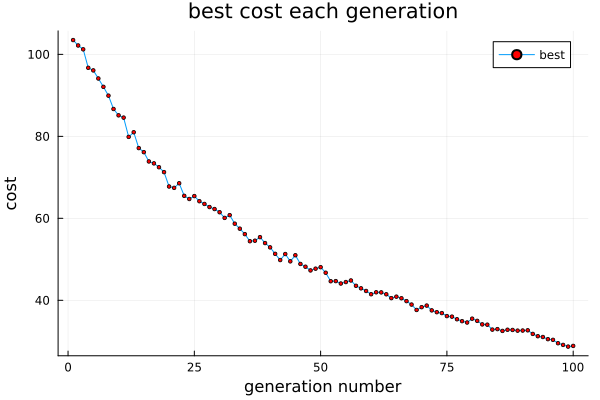

In [176]:
monte_carlo_sims = 50
max_generations = 100
pop_size = 20
dimensions = 20
min_val = zeros(monte_carlo_sims)
best_histories = []
S = RouletteSelection()
M = UniformMut(.02, -5, 5)
C = SinglePointCrossover()

# Number of Monte Carlo simulations
for i = 1:monte_carlo_sims
    
    population = rand_population_uniform(pop_size, dimensions, -5, 5)
    output, average_history, best_history = genetic_algorithm(sphere, population, max_generations, S, C, M)

    push!(best_histories, best_history)
    min_val[i] = minimum(best_history[100])
    #print(output)
    #println(sphere(output))
end

println("Cav(x*)=", mean(min_val))
mean_best_history = zeros(max_generations)
for i in 1:max_generations
    sum_val = 0
    for j in 1:length(best_histories)
        sum_val += best_histories[j][i]
    end
    mean_best_history[i] = sum_val / length(best_histories)
end
display(plot(1:1:max_generations, mean_best_history, title="best cost each generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))



The C_av(x*) in part c with 2% mutation rate regularly performs better than in part b.

## .c) Repeat B, with mutation rate of 5%

Cav(x*)=53.90723953729808

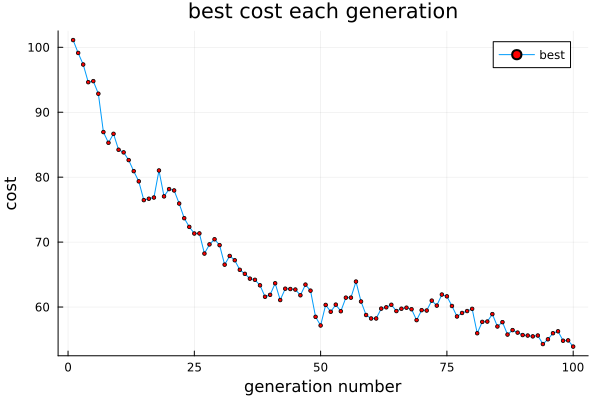

In [177]:
monte_carlo_sims = 50
generations = 100
pop_size = 20
dimensions = 20
min_val = zeros(monte_carlo_sims)
best_histories = []
S = RouletteSelection()
M = UniformMut(.05, -5, 5)
C = SinglePointCrossover()

# Number of Monte Carlo simulations
for i = 1:monte_carlo_sims

    population = rand_population_uniform(pop_size, dimensions, -5, 5)
    output, average_history, best_history = genetic_algorithm(sphere, population, max_generations, S, C, M)

    push!(best_histories, best_history)
    min_val[i] = minimum(best_history[100])
    #print(output)
    #println(sphere(output))
end

print("Cav(x*)=", mean(min_val))
mean_best_history = zeros(max_generations)
for i in 1:generations
    sum_val = 0
    for j in 1:length(best_histories)
        sum_val += best_histories[j][i]
    end
    mean_best_history[i] = sum_val / length(best_histories)
end
display(plot(1:1:max_generations, mean_best_history, title="best cost each generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))



The C_av(x*) in part c with 5% mutation rate regularly performs worse than part b and part c with 2%.

## Verification of Sphere Function

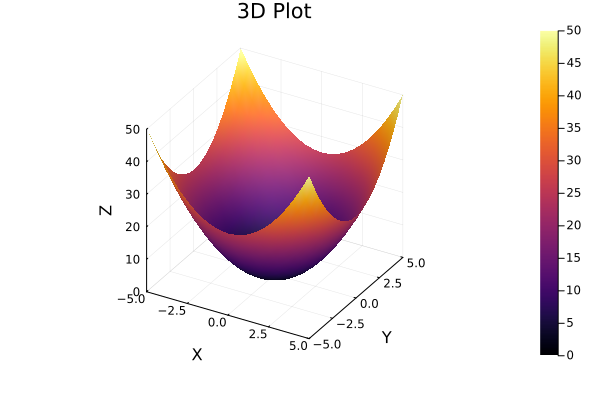

In [159]:
x_values = -5:.5:5
y_values = -5:.5:5
z_values = [sphere([i, j]) for i in x_values, j in y_values]
Plots.surface(x_values, y_values, z_values, xlabel="X", ylabel="Y", zlabel="Z", title="3D Plot")